In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle
import os

In [3]:
df = pd.read_csv('data/preprocessed/dataset.csv')

C:\Users\benja\AppData\Local\Temp\ipykernel_41960\3622772722.py:1: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/preprocessed/dataset.csv')


In [4]:
RANDOM_STATE = 42
SAVE_TRAIN_TEST = False
REPORT_ID = 'report_id'
GROUP_ID = 'fire_id'


test_size = 0.2
random_state = 42
features = ['report_number', 'incident_area', 'cause_id', 'month', 'year', 'STATUS']
target = 'diff_incident_area'
id_cols = [REPORT_ID, GROUP_ID]

In [5]:
MODELS = {
    'regression':
        {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(),
        "Lasso": Lasso(),
        'XGB': xgb.XGBRegressor(),
        #'RandomForest': RandomForestRegressor(),
        #'SVR': SVR()
        },
    'classification':
        {
        'LogisticRegression': LogisticRegression(),
        'XGB': xgb.XGBClassifier(),
        'RandomForest': RandomForestClassifier(),
        'SVC': SVC()
        }
}


In [6]:
hp_grid = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.1, 1, 10], 'max_iter': [1000, 2000, 3000]},
    "Lasso": {'alpha': [0.1, 1, 10], 'max_iter': [1000, 2000, 3000]},
    'XGB': {'n_estimators': [100, 200, 300], "learning_rate": [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7], "subsample": [0.5, 1]},
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'criterion': ["squared_error"]},
    'SVR': {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], "gamma": ["scale", "auto", 0.01, 0.1, 1, 10], 'C': [0.1, 1, 10]}
}

In [7]:
from sklearn.preprocessing import OneHotEncoder

def create_task_dataset(df, id_cols, features, target):
  """Feature and row selection, encoding

  Arguments:
      df {DataFrame} -- merged dataframe: incidents, reports, resources. A row is a report.
      features {List[str]} -- List of features to use for the task.
      target {str} -- target to predict
  """

  assert target in df.columns, f"Target {target} not in dataframe"
  assert all([col in df.columns for col in features]), f"Features {features} not in dataframe"
  assert all([col in df.columns for col in id_cols]), f"ID columns {id_cols} not in dataframe"
  assert len(features) > 0, "You need to select at least one feature"

  # Select features
  df = df[id_cols+ features + [target]]

  # Drop rows with missing values for target
  df = df.dropna(subset=[target])

  # Find categorical columns
  cat_cols = [col for col in df.columns if df[col].nunique() < 15]
  print(f"Identified {len(cat_cols)} categorical columns: \n{cat_cols}")
  potential = [col for col in df.columns if df[col].nunique() > 15 and df[col].nunique() < 100]
  print(f'\nYou should check these columns: \n{potential}')

  # One-hot encode categorical columns
  encoder = OneHotEncoder(sparse_output=False)
  encoded_data = encoder.fit_transform(df[cat_cols])
  encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cat_cols))
  df = df.drop(columns=cat_cols).reset_index(drop=True)
  encoded_df = pd.concat([df, encoded_df], axis=1)
  return encoded_df, encoder

In [9]:
task_df, encoder = create_task_dataset(df, id_cols, features, target)
non_id_cols = [col for col in task_df.columns if col not in id_cols]

Identified 4 categorical columns: 
['cause_id', 'month', 'year', 'STATUS']

You should check these columns: 
[]


## Visualizations

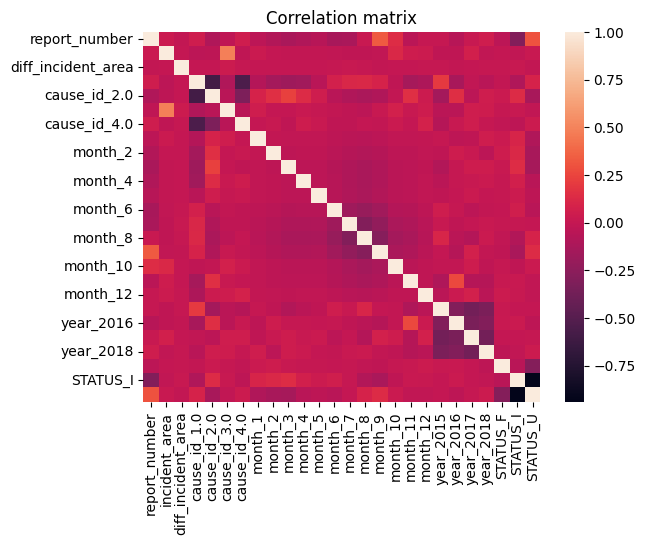

In [10]:
sns.heatmap(task_df[non_id_cols].corr())
plt.title('Correlation matrix');

In [11]:
task_df.shape

(37499, 28)

## Train and Test Split

In [12]:
def split_train_test(task_df, test_size, group_id, random_state=42, save_datasets=False):
  """Split data into train and test sets using groups (group_id)

  Arguments:
      task_df {DataFrame} --
      group_id {str} -- group identifier
      random_state {int} -- random state
      target {str} -- target feature
      save_datasets {bool} -- whether to save train and test sets (useful for later evals, tests)

  Returns:
      DataFrame -- train set
      DataFrame -- test set
  """
  assert group_id in task_df.columns, f'Group id {group_id} not in dataframe'
  assert test_size > 0 and test_size < 1, f'Test size {test_size} must be between 0 and 1'

  df = task_df.sample(frac=1, random_state=random_state)
  unique_ids = df[GROUP_ID].unique()
  train_ids, test_ids = train_test_split(unique_ids, test_size=test_size, random_state=random_state)
  train_df = df[df[GROUP_ID].isin(train_ids)]
  test_df = df[df[GROUP_ID].isin(test_ids)]
  if save_datasets:
    train_df.to_csv('data/preprocessed/train.csv', index=False)
    test_df.to_csv('data/preprocessed/test.csv', index=False)
  return train_df, test_df


In [76]:
def split_X_y(df, id_cols, target):
  """Split data into X and y

  Arguments:
      df {DataFrame} -- dataset
      id_cols {List[str]} -- identifiers columns (not features, not target)
      target {str} -- target feature

  Returns:
      DataFrame -- X
      DataFrame -- y
  """
  assert target in df.columns, f'{target} not in df.columns'
  assert all([col in df.columns for col in id_cols]), f'Not all id_cols in df.columns'

  X = df.drop(columns=[target]+id_cols)
  y = df[target]
  return X, y

In [77]:
train_df, test_df = split_train_test(task_df, test_size=test_size, group_id=GROUP_ID, random_state=random_state, save_datasets=SAVE_TRAIN_TEST)
X_test, y_test = split_X_y(test_df, id_cols, target)


## Train models

In [1]:
train_df

NameError: name 'train_df' is not defined

In [80]:
metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]

In [100]:

SCORING_METRIC = 'neg_mean_absolute_error'

def compute_cv_scores(train_df, n_splits, models, scoring_metric, random_state, id_cols, group_id,  save_best_estimators=False):
  """Compute the score of each model

  Arguments:
      X {DataFrame} -- features
      y {Series} -- target
      n_plit {int} -- number of cv splits
      models {Dict} -- dict of models

  Returns:
      DataFrame -- scores
  """
  searches = {}
  X, y = split_X_y(train_df, id_cols, target)
  gkf = GroupKFold(n_splits=n_splits)
  for model_name, model in models.items():
    print(f"Running RandomizedSearchCV for {model.__class__.__name__}")
    search = RandomizedSearchCV(
        model,
        hp_grid[model_name],
        scoring=scoring_metric,
        cv=gkf.split(X, y, groups=train_df[group_id]),
        refit=True,
        random_state=random_state,
        n_jobs=-1,
    )
    search.fit(X, y)
    searches[model_name] = search

    if save_best_estimators:
        folder_name = f"models/{scoring_metric}"
        if not os.path.exists(folder_name):
            os.makedirs(folder_name, exist_ok=True)
        with open(os.path.join(folder_name, f"{model_name}.pkl"), "wb") as f:
                pickle.dump(search.best_estimator_, f)
  return searches

In [79]:
searches = compute_cv_scores(train_df, 5, MODELS['regression'], "r2", RANDOM_STATE, id_cols, GROUP_ID, save_best_estimators=True)

Running RandomizedSearchCV for LinearRegression


c:\ProgramData\Anaconda3\envs\wildfirepy38\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running RandomizedSearchCV for Ridge


c:\ProgramData\Anaconda3\envs\wildfirepy38\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running RandomizedSearchCV for Lasso


c:\ProgramData\Anaconda3\envs\wildfirepy38\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Running RandomizedSearchCV for XGBRegressor


In [123]:
import json
def get_info_from_searches(searches):
  """Transform searches to a dict of details

  Arguments:
      searches {Dict} -- dict of searches

  Returns:
      Dict -- dict of details
  """
  searches_details = {}
  for model in searches.keys():
    print(model)
    model_details = {}
    model_details['best_score'] = searches[model].best_score_
    model_details['best_params'] = searches[model].best_params_
    model_details['std_test_score'] = searches[model].cv_results_['std_test_score'].tolist()
    model_details['mean_test_score'] = searches[model].cv_results_['mean_test_score'].tolist()
    searches_details[model] = model_details
  return searches_details

def save_info_from_searches(searches, filename, metric, overwrite=True):
  """Save searches details to a json file

  Arguments:
      searches {Dict} -- dict of searches
      filename {str} -- filename
  """
  infos = get_info_from_searches(searches)
  with open(filename, "r") as jsonfile:
    data = json.load(jsonfile)
  overwrite = True
  metric = "r2"
  optimizer = RandomizedSearchCV.__name__
  if metric in data.keys():
      if optimizer not in data[metric].keys() or overwrite:
          data[metric][optimizer] = infos
      else:
          print(f"Searches for {optimizer} already in {metric}.json")
  else:
      data[metric] = {optimizer: infos}

  with open("models/hp_searches.json", "w") as jsonfile:
      json.dump(data, jsonfile)


In [124]:
save_info_from_searches(searches, "models/hp_searches.json", "r2", overwrite=True)

LinearRegression
Ridge
Lasso
XGB


In [ ]:
def cv_train(
    train_df,
    n_splits,
    model,
    scoring_metric,
    random_state,
    id_cols,
    group_id,
    save_best_estimators=False,
):
    """Compute the score of each model

    Arguments:
        X {DataFrame} -- features
        y {Series} -- target
        n_plit {int} -- number of cv splits
        models {Dict} -- dict of models

    Returns:
        DataFrame -- scores
    """
    searches = {}
    X, y = split_X_y(train_df, id_cols, target)
    gkf = GroupKFold(n_splits=n_splits)
        search = RandomizedSearchCV(
            model,
            hp_grid[model_name],
            scoring=scoring_metric,
            cv=gkf.split(X, y, groups=train_df[group_id]),
            refit=True,
            random_state=random_state,
            n_jobs=-1,
        )
        search.fit(X, y)
        searches[model_name] = search

        if save_best_estimators:
            folder_name = f"models/{scoring_metric}"
            if not os.path.exists(folder_name):
                os.makedirs(folder_name, exist_ok=True)
            with open(os.path.join(folder_name, f"{model_name}.pkl"), "wb") as f:
                pickle.dump(search.best_estimator_, f)
    return searches